# Reconstruct HRTF using PCA, learn PCs using DNN

In [1]:
%load_ext autoreload
%autoreload 2

In [619]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
from IPython.display import display, Markdown, Latex
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from utils_data import load_hutubs_1
from utils_model_1d import create_dnn_dense
from utils_train import train_model_chen2019_dnn
from utils_plot import plot_reconstructions_chen2019, plot_xcorr, plot_latent_space

## Dataset settings

In [585]:
## show all possible setups
azimuths = sio.loadmat('./data/hutubs_hrtf/configs.mat')['azimuths'][0]
elevations = sio.loadmat('./data/hutubs_hrtf/configs.mat')['elevations'][0]
freqs = sio.loadmat('./data/hutubs_hrtf/configs.mat')['f'][0]
viable_ids = [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
      17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
      34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
      51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
      68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84,
      85, 86, 87, 89, 90, 91, 93, 94, 95]
print('azimuths: ', azimuths) 
print('elevations: ', elevations)
print('viable IDs: ', viable_ids)

azimuths:  [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355]
elevations:  [-85 -80 -75 -70 -65 -60 -55 -50 -45 -40 -35 -30 -25 -20 -15 -10  -5   0
   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90]
viable IDs:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 93, 94, 95]


In [598]:
## SETTINGS 
ids = np.array(viable_ids)
filters = {
    'ears': ['left'],
    'azimuths': (np.arange(-45,46,5) % 360),
    'elevations': np.arange(-45,46,5)
}
n_splits = 10
n_pc = 20
f_range = (300, 16000)
filters_layers = [64, 64]
batch_size = 512
epochs = 100
print('ids', ids)
print(filters)

ids [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 80 81 82 83 84 85 86 87 89 90 91 93 94 95]
{'ears': ['left'], 'azimuths': array([315, 320, 325, 330, 335, 340, 345, 350, 355,   0,   5,  10,  15,
        20,  25,  30,  35,  40,  45]), 'elevations': array([-45, -40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,
        20,  25,  30,  35,  40,  45])}


In [599]:
## some useful functions
def spectral_distortion(hrtf_true, hrtf_pred, freqs, f_range):
    fmin, fmax = f_range
    # get bins in range
    f_idx = []
    for i,f in enumerate(freqs):
        if f > fmin and f < fmax:
            f_idx.append(i)
    # formula: sqrt(1/N * sum(square(H_true(f) - H_pred(f))))
    sd_db = np.sqrt((1/len(f_idx)) * np.sum(np.power(hrtf_true[:,f_idx] - hrtf_pred[:,f_idx], 2), axis=1))
    # dB to linear
    #sd = 10 ** (sd_db/20)
    return sd_db

def normalize_hrtf(hrtf, x_mean, x_std):
    hrtf_n = hrtf.copy()
    hrtf_n -= x_mean
    hrtf_n /= x_std
    return hrtf_n

def denormalize_hrtf(hrtf, x_mean, x_std):
    hrtf_n = hrtf.copy()
    hrtf_n *= x_std
    hrtf_n += x_mean
    return hrtf_n

In [600]:
# load and process all hrtf data
# this function uses the global variables definen above
def load_hrtf_sets(train_index, test_index):
    # get lists of subjects
    ids_train, ids_test = ids[train_index], ids[test_index]
    # load train and test sets
    filters['ids'] = ids_train
    x_train, y_train = load_hutubs_1(
            dataset_path='./data/hutubs_hrtf/', 
            anthropometrics_path='./data/hutubs_measures.csv', 
            data_content='hrtfs',
            user_filters=filters)
    filters['ids'] = ids_test
    x_test, y_test = load_hutubs_1(
            dataset_path='./data/hutubs_hrtf/', 
            anthropometrics_path='./data/hutubs_measures.csv', 
            data_content='hrtfs',
            user_filters=filters)
    # sort azimuth labels
    y_train['azimuth'] = [a if a<=180 else (a-360) for a in y_train['azimuth']]
    y_test['azimuth'] = [a if a<=180 else (a-360) for a in y_test['azimuth']]
    # scale data to mean=0, std=0
    x_train_mean = 0 #x_train.mean()
    x_train_std = 1 #x_train.std()
    x_train = normalize_hrtf(x_train, x_train_mean, x_train_std)
    x_test = normalize_hrtf(x_test, x_train_mean, x_train_std)
    # printo infos    
    print('train set:', x_train.shape)
    print('test set: ', x_test.shape)
    return (x_train, y_train), (x_test, y_test), (x_train_mean, x_train_std)

In [601]:
# load and process anthropometrics and PC data used by DNN
#
def load_dnndata_sets(x_train_pca, y_train, x_test_pca, y_test):
    drop_cols = ['id', 'ear', 'ear_n', 'n1']
    x_train_dnn = y_train.drop(columns=drop_cols).copy()
    y_train_dnn = x_train_pca.copy()
    x_test_dnn = y_test.drop(columns=drop_cols).copy()
    y_test_dnn = x_test_pca.copy()
    # scale data to mean=0, std=0
    #scaler = StandardScaler()
    #x_train_dnn.loc[:] = scaler.fit_transform(x_train_dnn)
    #x_test_dnn.loc[:] = scaler.transform(x_test_dnn)
    # print infos
    print('train set:', x_train_dnn.shape)
    print('test set: ', x_test_dnn.shape)
    #print((x_train_dnn.describe() - x_test_dnn.describe()).round(2))
    return (x_train_dnn, y_train_dnn), (x_test_dnn, y_test_dnn)

In [602]:
# calculate spectral distortion on given freq range
#
def calc_sd(x, x_rec, x_mean, x_std, f_range):
    hrtf_true = denormalize_hrtf(x, x_mean, x_std)
    hrtf_pred = denormalize_hrtf(x_rec, x_mean, x_std)
    sd = spectral_distortion(hrtf_true, hrtf_pred, freqs, f_range)
    return sd


# calculate spectral distortion on given freq range, minimizing SD by applying offset
# (slightly less lazy implementation)
def calc_sd_minimize(x, x_rec, x_mean, x_std, f_range):
    n_offsets = 32
    offsets = np.linspace(-5,5,n_offsets)

    n_samples = x.shape[0]
    sd = np.zeros((n_offsets, n_samples))
    
    hrtf_true = denormalize_hrtf(x, x_mean, x_std)
    hrtf_pred = denormalize_hrtf(x_rec, x_mean, x_std)
    
    for i, offs in enumerate(offsets):
        sd[i] = spectral_distortion(hrtf_true, hrtf_pred+offs, freqs, f_range)
    return sd.min(axis=0)


In [603]:
# calculate PCA loadings on HRTF train set and train DNN on anthropometrics train set;
# predict PCs using DNN and reconstruct HRTFs using PCA loadings on train and test sets
class PCADNN():        
    def pca_train(self, x_train, n_pc):
        self.pca = PCA(n_pc)
        self.pca.fit(x_train)

    def pca_compress(self, x):
        x_pca = self.pca.transform(x)
        x_rec = self.pca.inverse_transform(x_pca)
        return x_pca, x_rec
    
    def pc_to_df(self, x_pca, y):
        pca_cols = [f'PC{i}' for i in range(x_pca.shape[1])]
        x_pca_df = pd.DataFrame(x_pca, columns=pca_cols)
        x_pca_df['azimuth'] = y['azimuth']
        x_pca_df['elevation'] = y['elevation']
        x_pca_df['id'] = y['id']
        return x_pca_df    
    
    def dnn_train(self, x_train_dnn, y_train_dnn, x_test_dnn, y_test_dnn, filters_layers, batch_size, epochs, name):
        self.dnn = create_dnn_dense(n_input=x_train_dnn.shape[1], 
                                    filters_layers=filters_layers, 
                                    n_outputs=y_train_dnn.shape[1])
        # pre-compute some info for training
        
        tensorboard_destination = f'./logs/{name}'

        # training parameters
        validation_freq = 5
        earlystopping_patience = -50
        checkpoint_destination = None
        cuda_device = '2'
        tqdm_bar = True

        # train the autoencoder
        epochs_range = [0, epochs]
        print(f'Training log: {tensorboard_destination}')
        print(f'Training {name} from {epochs_range[0]} to {epochs_range[1]}..')
        train_model_chen2019_dnn(self.dnn, x_train_dnn, y_train_dnn, x_test_dnn, y_test_dnn, 
                                  batch_size, epochs_range=epochs_range,
                                  validation_freq=validation_freq,
                                  tqdm_bar=tqdm_bar,
                                  earlystopping_patience=earlystopping_patience, 
                                  checkpoint_destination=checkpoint_destination, 
                                  tensorboard_destination=tensorboard_destination, 
                                  cuda_device=cuda_device)
        
    def model_apply(self, x_dnn):
        x_pca = self.dnn.predict(x_dnn)
        hrtf_pred = self.pca.inverse_transform(x_pca)
        return hrtf_pred
    

In [604]:
# plot sample normalized HRTFs
# 
def plot_norm_hrtfs(x, y, nr=3, nc=5):
    w = nc*2.8
    h = nr*1.3
    f = sio.loadmat('./data/hutubs_hrtf/configs.mat')['f'][0]
    offs = 30

    fig, ax = plt.subplots(nr, nc, figsize=(w, h))
    for i, a in enumerate(ax.flatten()):
        a.plot(f, x[i])
        a.set_title('#{:02}{} ({:.0f}° ; {:.0f}°)'.format(
                y['id'].iloc[i], y['ear'].iloc[i][0].upper(),
                y['azimuth'].iloc[i], y['elevation'].iloc[i]))    
        #a.set_ylim([-1.2, 1.2])
        a.set_xlim([0, 18000])
        #a.set_yticks(np.arange(-1.5, 1.51, 0.5))
        a.yaxis.grid()
        a.set_yticklabels([])
        a.set_xticklabels([])
        #a.axis('off')
    fig.suptitle('Sample HRTFs', fontsize=16)
    fig.tight_layout(rect=[0,0,1,0.94])
    plt.show()


In [605]:
# plot combination of PCs
#
def plot_pca_pairs(x_pca_df, subset, n_pairs=5, step=7):
    pca_cols = [f'PC{i}' for i in range(n_pairs)]
    p = sns.pairplot(data=x_pca_df.iloc[::step], vars=pca_cols, hue='azimuth', height=2.5, palette=("viridis"))
    plt.subplots_adjust(top=0.96)
    p.fig.suptitle(f'Datapoints in PC space ({subset} set)', fontsize=16)
    plt.show()

In [606]:
# plot pairs of true/reconstructed HRTFs
#
def plot_rec_hrtf(x, x_rec, y, subset, nr=3, nc=5):
    w = nc*2.8
    h = nr*1.3

    fig, ax = plt.subplots(nr, nc, figsize=(w, h))
    for i, a in enumerate(ax.flatten()):
        a.plot(freqs, x[i])
        a.plot(freqs, x_rec[i])
        if i == 0:
            a.legend(['true', 'rec'])
        a.set_title('#{:02}{} ({:.0f}° ; {:.0f}°)'.format(
                y['id'].iloc[i], 
                y['ear'].iloc[i][0].upper(),
                y['azimuth'].iloc[i], 
                y['elevation'].iloc[i]))    
    fig.suptitle(f'Sample true/reconstructed HRTFs ({subset} set)', fontsize=16)
    fig.tight_layout(rect=[0,0,1,0.96])
    plt.show()

In [607]:
# plot correlation matrix
#
def plot_corr(x_pca_df, y, subset):
    drop_cols_y = ['ear', 'id', 'x6', 'x7', 'x8', 'x9', 'x14', 'x17', 'x2', 'x3', 'x1']
    drop_cols_x = ['azimuth', 'elevation', 'id']
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    xcorr = pd.concat([x_pca_df.drop(columns=drop_cols_x), y.drop(columns=drop_cols_y).astype(float)], axis=1, keys=['df1', 'df2'])
    corr = xcorr.corr().loc['df1', 'df2']
    sns.heatmap(data=corr, cmap=cmap, vmin=-0.9, vmax=0.9,
                center=0, square=True, annot=True, fmt='.2f',
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_ylim(len(corr)+0.5, -0.5)
    fig.suptitle(f'Correlation between anthropometrics and PCs ({subset} set)', fontsize=16)
    fig.tight_layout(rect=[0,0,0.95,0.98])
    plt.show()


## Find ideal number of PC

## Fold 1/10

100%|██████████| 3249/3249 [00:03<00:00, 1071.42it/s]


train set: (29241, 128)
test set:  (3249, 128)


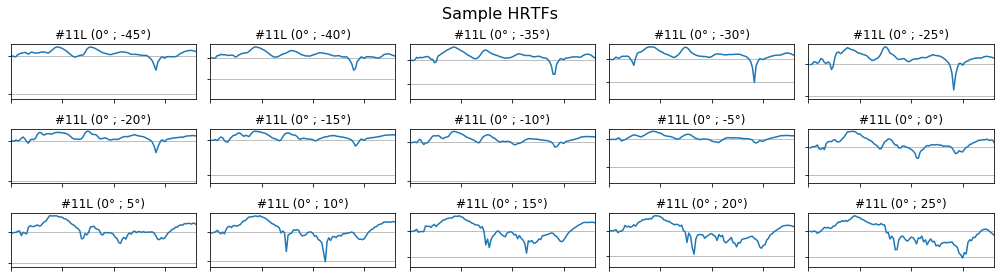

### Apply PCA on train

Max SD (train): 3.4744798790251377


### Apply PCA on test

Max SD (test): 3.2982355096610365


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_01
Training dnn_73262387_fold_01 from 0 to 100..


loss: 413.0126, val_loss: 452.7116: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 27)                0         
_________________________________________________________________
dnn_0_dense (Dense)          (None, 64)                1792      
_________________________________________________________________
dnn_0_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_0_act (Activation)       (None, 64)                0         
_________________________________________________________________
dnn_1_dense (Dense)          (None, 64)                4160      
_________________________________________________________________
dnn_1_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_1_act (Activation)       (None, 64)                0         
__________

### Apply PCA/DNN model on train

SD (train): 4.580716540929358


### Apply PCA/DNN model on test

SD (test): 4.605248687520515


### Apply PCA on train

Max SD (train): 2.867620054392208


### Apply PCA on test

Max SD (test): 2.6659811359323973


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_01
Training dnn_73262387_fold_01 from 0 to 100..


loss: 361.9659, val_loss: 400.0555: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 27)                0         
_________________________________________________________________
dnn_0_dense (Dense)          (None, 64)                1792      
_________________________________________________________________
dnn_0_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_0_act (Activation)       (None, 64)                0         
_________________________________________________________________
dnn_1_dense (Dense)          (None, 64)                4160      
_________________________________________________________________
dnn_1_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_1_act (Activation)       (None, 64)                0         
__________

### Apply PCA/DNN model on train

SD (train): 4.580693729916793


### Apply PCA/DNN model on test

SD (test): 4.554152447598979


### Apply PCA on train

Max SD (train): 2.574786700238625


### Apply PCA on test

Max SD (test): 2.3873390502751923


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_01
Training dnn_73262387_fold_01 from 0 to 100..


loss: 317.9441, val_loss: 333.7756: 100%|██████████| 100/100 [01:00<00:00,  1.67it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 27)                0         
_________________________________________________________________
dnn_0_dense (Dense)          (None, 64)                1792      
_________________________________________________________________
dnn_0_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_0_act (Activation)       (None, 64)                0         
_________________________________________________________________
dnn_1_dense (Dense)          (None, 64)                4160      
_________________________________________________________________
dnn_1_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_1_act (Activation)       (None, 64)                0         
__________

### Apply PCA/DNN model on train

SD (train): 4.540244022584415


### Apply PCA/DNN model on test

SD (test): 4.5151583230808985


### Apply PCA on train

Max SD (train): 2.3326813643237014


### Apply PCA on test

Max SD (test): 2.176904795426836


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_01
Training dnn_73262387_fold_01 from 0 to 100..


loss: 279.0226, val_loss: 298.9964: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 27)                0         
_________________________________________________________________
dnn_0_dense (Dense)          (None, 64)                1792      
_________________________________________________________________
dnn_0_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_0_act (Activation)       (None, 64)                0         
_________________________________________________________________
dnn_1_dense (Dense)          (None, 64)                4160      
_________________________________________________________________
dnn_1_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_1_act (Activation)       (None, 64)                0         
__________

### Apply PCA/DNN model on train

SD (train): 4.5255542884525894


### Apply PCA/DNN model on test

SD (test): 4.532280429695588


### Apply PCA on train

Max SD (train): 2.0737477887735687


### Apply PCA on test

Max SD (test): 1.922989998421357


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_01
Training dnn_73262387_fold_01 from 0 to 100..


loss: 254.1165, val_loss: 264.9181: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 27)                0         
_________________________________________________________________
dnn_0_dense (Dense)          (None, 64)                1792      
_________________________________________________________________
dnn_0_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_0_act (Activation)       (None, 64)                0         
_________________________________________________________________
dnn_1_dense (Dense)          (None, 64)                4160      
_________________________________________________________________
dnn_1_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_1_act (Activation)       (None, 64)                0         
__________

### Apply PCA/DNN model on train

SD (train): 4.578417908153283


### Apply PCA/DNN model on test

SD (test): 4.507924818760797


### Apply PCA on train

Max SD (train): 1.9403360072889497


### Apply PCA on test

Max SD (test): 1.7968890948165348


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_01
Training dnn_73262387_fold_01 from 0 to 100..


loss: 228.2398, val_loss: 238.5066: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 27)                0         
_________________________________________________________________
dnn_0_dense (Dense)          (None, 64)                1792      
_________________________________________________________________
dnn_0_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_0_act (Activation)       (None, 64)                0         
_________________________________________________________________
dnn_1_dense (Dense)          (None, 64)                4160      
_________________________________________________________________
dnn_1_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_1_act (Activation)       (None, 64)                0         
__________

### Apply PCA/DNN model on train

SD (train): 4.564625888606196


### Apply PCA/DNN model on test

SD (test): 4.51671107462065


### Apply PCA on train

Max SD (train): 1.822056028936982


### Apply PCA on test

Max SD (test): 1.6631857375223422


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_01
Training dnn_73262387_fold_01 from 0 to 100..


loss: 203.5755, val_loss: 215.2174: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 27)                0         
_________________________________________________________________
dnn_0_dense (Dense)          (None, 64)                1792      
_________________________________________________________________
dnn_0_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_0_act (Activation)       (None, 64)                0         
_________________________________________________________________
dnn_1_dense (Dense)          (None, 64)                4160      
_________________________________________________________________
dnn_1_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_1_act (Activation)       (None, 64)                0         
__________

### Apply PCA/DNN model on train

SD (train): 4.524225861882232


### Apply PCA/DNN model on test

SD (test): 4.512878584091568


### Apply PCA on train

Max SD (train): 1.677918933192969


### Apply PCA on test

Max SD (test): 1.4922856718051014


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_01
Training dnn_73262387_fold_01 from 0 to 100..


loss: 185.5947, val_loss: 199.4582: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 27)                0         
_________________________________________________________________
dnn_0_dense (Dense)          (None, 64)                1792      
_________________________________________________________________
dnn_0_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_0_act (Activation)       (None, 64)                0         
_________________________________________________________________
dnn_1_dense (Dense)          (None, 64)                4160      
_________________________________________________________________
dnn_1_do (Dropout)           (None, 64)                0         
_________________________________________________________________
dnn_1_act (Activation)       (None, 64)                0         
__________

### Apply PCA/DNN model on train

SD (train): 4.544702952803292


### Apply PCA/DNN model on test

SD (test): 4.567080613182692


## Fold 2/10

100%|██████████| 3249/3249 [00:03<00:00, 1080.08it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 3.4601215882054404


### Apply PCA on test

Max SD (test): 3.842120443967905


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_02
Training dnn_73262387_fold_02 from 0 to 100..


loss: 420.4523, val_loss: 371.4659: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


### Apply PCA/DNN model on train

SD (train): 4.554235046106122


### Apply PCA/DNN model on test

SD (test): 4.734099757472056


### Apply PCA on train

Max SD (train): 2.8953944441852295


### Apply PCA on test

Max SD (test): 3.2523117851138896


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_02
Training dnn_73262387_fold_02 from 0 to 100..


loss: 364.2779, val_loss: 339.8105: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


### Apply PCA/DNN model on train

SD (train): 4.532838563872628


### Apply PCA/DNN model on test

SD (test): 4.664551137646176


### Apply PCA on train

Max SD (train): 2.5470928620365925


### Apply PCA on test

Max SD (test): 2.6673304833355433


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_02
Training dnn_73262387_fold_02 from 0 to 100..


loss: 320.1962, val_loss: 326.4202: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


### Apply PCA/DNN model on train

SD (train): 4.5224105190488535


### Apply PCA/DNN model on test

SD (test): 4.670043229364116


### Apply PCA on train

Max SD (train): 2.311687504811848


### Apply PCA on test

Max SD (test): 2.5146775548099103


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_02
Training dnn_73262387_fold_02 from 0 to 100..


loss: 279.7674, val_loss: 285.8709: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


### Apply PCA/DNN model on train

SD (train): 4.499778640718705


### Apply PCA/DNN model on test

SD (test): 4.659079940130613


### Apply PCA on train

Max SD (train): 2.056393907370543


### Apply PCA on test

Max SD (test): 2.1943620209958077


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_02
Training dnn_73262387_fold_02 from 0 to 100..


loss: 249.6127, val_loss: 263.3716: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


### Apply PCA/DNN model on train

SD (train): 4.508651280356673


### Apply PCA/DNN model on test

SD (test): 4.68485263479213


### Apply PCA on train

Max SD (train): 1.8994421650174451


### Apply PCA on test

Max SD (test): 2.037870593969931


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_02
Training dnn_73262387_fold_02 from 0 to 100..


loss: 226.0622, val_loss: 233.8917: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


### Apply PCA/DNN model on train

SD (train): 4.556700732746917


### Apply PCA/DNN model on test

SD (test): 4.718053813336321


### Apply PCA on train

Max SD (train): 1.7568095237863999


### Apply PCA on test

Max SD (test): 1.8985440102046651


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_02
Training dnn_73262387_fold_02 from 0 to 100..


loss: 203.3227, val_loss: 205.1851: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


### Apply PCA/DNN model on train

SD (train): 4.5010935665758405


### Apply PCA/DNN model on test

SD (test): 4.626359278830741


### Apply PCA on train

Max SD (train): 1.6604290584454515


### Apply PCA on test

Max SD (test): 1.7736972249497922


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)


loss: 635.1896, val_loss: 661.6302:  57%|█████▋    | 57/100 [7:35:06<5:43:19, 479.06s/it]


Training log: ./logs/dnn_73262387_fold_02
Training dnn_73262387_fold_02 from 0 to 100..


loss: 187.4546, val_loss: 191.4622: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


### Apply PCA/DNN model on train

SD (train): 4.541258219342221


### Apply PCA/DNN model on test

SD (test): 4.68748372396171


## Fold 3/10

100%|██████████| 3249/3249 [00:03<00:00, 1072.74it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 3.4731207264785953


### Apply PCA on test

Max SD (test): 3.3433681670422195


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_03
Training dnn_73262387_fold_03 from 0 to 100..


loss: 419.1691, val_loss: 363.4811: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


### Apply PCA/DNN model on train

SD (train): 4.585300586143931


### Apply PCA/DNN model on test

SD (test): 4.331407757996187


### Apply PCA on train

Max SD (train): 2.8878725806051446


### Apply PCA on test

Max SD (test): 2.872198608106273


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_03
Training dnn_73262387_fold_03 from 0 to 100..


loss: 363.8085, val_loss: 301.2489: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


### Apply PCA/DNN model on train

SD (train): 4.531912729485043


### Apply PCA/DNN model on test

SD (test): 4.243857973741492


### Apply PCA on train

Max SD (train): 2.5548982365654207


### Apply PCA on test

Max SD (test): 2.5371373875821748


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_03
Training dnn_73262387_fold_03 from 0 to 100..


loss: 326.7343, val_loss: 279.6768: 100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


### Apply PCA/DNN model on train

SD (train): 4.597450120139763


### Apply PCA/DNN model on test

SD (test): 4.267774156332537


### Apply PCA on train

Max SD (train): 2.3379236601294227


### Apply PCA on test

Max SD (test): 2.2699749596658343


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_03
Training dnn_73262387_fold_03 from 0 to 100..


loss: 286.3554, val_loss: 244.0190: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


### Apply PCA/DNN model on train

SD (train): 4.573510929584452


### Apply PCA/DNN model on test

SD (test): 4.277419917829102


### Apply PCA on train

Max SD (train): 2.0744115599891004


### Apply PCA on test

Max SD (test): 1.9659120527638658


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_03
Training dnn_73262387_fold_03 from 0 to 100..


loss: 254.6669, val_loss: 218.3024: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


### Apply PCA/DNN model on train

SD (train): 4.560515853083495


### Apply PCA/DNN model on test

SD (test): 4.276269427867696


### Apply PCA on train

Max SD (train): 1.9249914303807536


### Apply PCA on test

Max SD (test): 1.8605732830925048


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_03
Training dnn_73262387_fold_03 from 0 to 100..


loss: 229.9231, val_loss: 196.9690: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


### Apply PCA/DNN model on train

SD (train): 4.604412592585733


### Apply PCA/DNN model on test

SD (test): 4.271068743406647


### Apply PCA on train

Max SD (train): 1.7748817682471267


### Apply PCA on test

Max SD (test): 1.7329417738228523


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_03
Training dnn_73262387_fold_03 from 0 to 100..


loss: 209.6704, val_loss: 183.2108: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


### Apply PCA/DNN model on train

SD (train): 4.610014174114807


### Apply PCA/DNN model on test

SD (test): 4.273225703053038


### Apply PCA on train

Max SD (train): 1.6681175233373398


### Apply PCA on test

Max SD (test): 1.6290956006334174


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_03
Training dnn_73262387_fold_03 from 0 to 100..


loss: 189.6645, val_loss: 170.7559: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


### Apply PCA/DNN model on train

SD (train): 4.554630135810345


### Apply PCA/DNN model on test

SD (test): 4.3260942267727325


## Fold 4/10

100%|██████████| 3249/3249 [00:02<00:00, 1118.84it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 3.445099200257539


### Apply PCA on test

Max SD (test): 3.634229166361278


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_04
Training dnn_73262387_fold_04 from 0 to 100..


loss: 423.2623, val_loss: 455.3028: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


### Apply PCA/DNN model on train

SD (train): 4.5801222783926105


### Apply PCA/DNN model on test

SD (test): 5.011863382571644


### Apply PCA on train

Max SD (train): 2.8945627685728694


### Apply PCA on test

Max SD (test): 3.0375988100761546


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_04
Training dnn_73262387_fold_04 from 0 to 100..


loss: 363.8970, val_loss: 391.1222: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


### Apply PCA/DNN model on train

SD (train): 4.54393196414022


### Apply PCA/DNN model on test

SD (test): 4.960285820274796


### Apply PCA on train

Max SD (train): 2.540290481376861


### Apply PCA on test

Max SD (test): 2.685449052286096


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_04
Training dnn_73262387_fold_04 from 0 to 100..


loss: 317.5573, val_loss: 335.3106: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


### Apply PCA/DNN model on train

SD (train): 4.490168570541194


### Apply PCA/DNN model on test

SD (test): 4.946174068001293


### Apply PCA on train

Max SD (train): 2.3201940054034136


### Apply PCA on test

Max SD (test): 2.430288650591656


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_04
Training dnn_73262387_fold_04 from 0 to 100..


loss: 279.2012, val_loss: 299.7524: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


### Apply PCA/DNN model on train

SD (train): 4.504547190398176


### Apply PCA/DNN model on test

SD (test): 4.959917578561901


### Apply PCA on train

Max SD (train): 2.059217450012319


### Apply PCA on test

Max SD (test): 2.202040612083116


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_04
Training dnn_73262387_fold_04 from 0 to 100..


loss: 247.1323, val_loss: 263.2831: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


### Apply PCA/DNN model on train

SD (train): 4.455623049462366


### Apply PCA/DNN model on test

SD (test): 4.960243630943175


### Apply PCA on train

Max SD (train): 1.9196632898874721


### Apply PCA on test

Max SD (test): 1.9991534065954266


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_04
Training dnn_73262387_fold_04 from 0 to 100..


loss: 225.3394, val_loss: 239.6852: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


### Apply PCA/DNN model on train

SD (train): 4.501574231803553


### Apply PCA/DNN model on test

SD (test): 4.9459746722617774


### Apply PCA on train

Max SD (train): 1.7703738210368065


### Apply PCA on test

Max SD (test): 1.8203664548458725


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_04
Training dnn_73262387_fold_04 from 0 to 100..


loss: 208.0592, val_loss: 220.4462: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


### Apply PCA/DNN model on train

SD (train): 4.535718219418709


### Apply PCA/DNN model on test

SD (test): 4.956992593389029


### Apply PCA on train

Max SD (train): 1.6544927892991663


### Apply PCA on test

Max SD (test): 1.7121548574335637


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_04
Training dnn_73262387_fold_04 from 0 to 100..


loss: 183.9429, val_loss: 202.7329: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


### Apply PCA/DNN model on train

SD (train): 4.452448646681847


### Apply PCA/DNN model on test

SD (test): 4.982588750725732


## Fold 5/10

100%|██████████| 3249/3249 [00:02<00:00, 1120.85it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 3.427113953530291


### Apply PCA on test

Max SD (test): 3.6114868150127344


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_05
Training dnn_73262387_fold_05 from 0 to 100..


loss: 425.3883, val_loss: 421.2459: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


### Apply PCA/DNN model on train

SD (train): 4.609455590220444


### Apply PCA/DNN model on test

SD (test): 4.733097889375498


### Apply PCA on train

Max SD (train): 2.8988293357916683


### Apply PCA on test

Max SD (test): 3.1665895747066326


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_05
Training dnn_73262387_fold_05 from 0 to 100..


loss: 362.4944, val_loss: 349.3249: 100%|██████████| 100/100 [01:03<00:00,  1.59it/s]


### Apply PCA/DNN model on train

SD (train): 4.534928389652394


### Apply PCA/DNN model on test

SD (test): 4.667336739690194


### Apply PCA on train

Max SD (train): 2.542755218997505


### Apply PCA on test

Max SD (test): 2.831421487348523


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_05
Training dnn_73262387_fold_05 from 0 to 100..


loss: 319.9693, val_loss: 318.3826: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


### Apply PCA/DNN model on train

SD (train): 4.522247851358936


### Apply PCA/DNN model on test

SD (test): 4.708592696968756


### Apply PCA on train

Max SD (train): 2.302822641503592


### Apply PCA on test

Max SD (test): 2.5463855394706436


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_05
Training dnn_73262387_fold_05 from 0 to 100..


loss: 282.8270, val_loss: 276.1762: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


### Apply PCA/DNN model on train

SD (train): 4.52229077127823


### Apply PCA/DNN model on test

SD (test): 4.671172949824522


### Apply PCA on train

Max SD (train): 2.0432511937665176


### Apply PCA on test

Max SD (test): 2.23710222561111


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_05
Training dnn_73262387_fold_05 from 0 to 100..


loss: 249.5704, val_loss: 260.4313: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


### Apply PCA/DNN model on train

SD (train): 4.518649694563921


### Apply PCA/DNN model on test

SD (test): 4.704830823588143


### Apply PCA on train

Max SD (train): 1.9088536170236525


### Apply PCA on test

Max SD (test): 2.067400150069716


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_05
Training dnn_73262387_fold_05 from 0 to 100..


loss: 227.9102, val_loss: 231.1138: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


### Apply PCA/DNN model on train

SD (train): 4.56051189381704


### Apply PCA/DNN model on test

SD (test): 4.685038682991376


### Apply PCA on train

Max SD (train): 1.7598701947982422


### Apply PCA on test

Max SD (test): 1.9301575139015381


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_05
Training dnn_73262387_fold_05 from 0 to 100..


loss: 205.0456, val_loss: 218.7075: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


### Apply PCA/DNN model on train

SD (train): 4.531398096728107


### Apply PCA/DNN model on test

SD (test): 4.742780571961824


### Apply PCA on train

Max SD (train): 1.6572492391084133


### Apply PCA on test

Max SD (test): 1.808599728785575


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_05
Training dnn_73262387_fold_05 from 0 to 100..


loss: 189.5558, val_loss: 190.0216: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


### Apply PCA/DNN model on train

SD (train): 4.566445272038853


### Apply PCA/DNN model on test

SD (test): 4.701635717254293


## Fold 6/10

100%|██████████| 3249/3249 [00:02<00:00, 1119.31it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 3.465658155928671


### Apply PCA on test

Max SD (test): 3.4442339278374785


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_06
Training dnn_73262387_fold_06 from 0 to 100..


loss: 428.9110, val_loss: 360.2343: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


### Apply PCA/DNN model on train

SD (train): 4.615950158074825


### Apply PCA/DNN model on test

SD (test): 4.358363883799335


### Apply PCA on train

Max SD (train): 2.91357264939437


### Apply PCA on test

Max SD (test): 3.0060531006025273


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_06
Training dnn_73262387_fold_06 from 0 to 100..


loss: 367.2814, val_loss: 298.5924: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


### Apply PCA/DNN model on train

SD (train): 4.540590785593136


### Apply PCA/DNN model on test

SD (test): 4.320222928120388


### Apply PCA on train

Max SD (train): 2.5449421458773904


### Apply PCA on test

Max SD (test): 2.6685312994051946


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_06
Training dnn_73262387_fold_06 from 0 to 100..


loss: 326.3202, val_loss: 272.3693: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


### Apply PCA/DNN model on train

SD (train): 4.569434552475636


### Apply PCA/DNN model on test

SD (test): 4.315715293918051


### Apply PCA on train

Max SD (train): 2.3266501059612166


### Apply PCA on test

Max SD (test): 2.392439094852277


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_06
Training dnn_73262387_fold_06 from 0 to 100..


loss: 289.5367, val_loss: 238.7400: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


### Apply PCA/DNN model on train

SD (train): 4.575793693906886


### Apply PCA/DNN model on test

SD (test): 4.309298732910673


### Apply PCA on train

Max SD (train): 2.065269373844042


### Apply PCA on test

Max SD (test): 2.114416086241834


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_06
Training dnn_73262387_fold_06 from 0 to 100..


loss: 258.0125, val_loss: 217.1636: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


### Apply PCA/DNN model on train

SD (train): 4.576659081737379


### Apply PCA/DNN model on test

SD (test): 4.293076907992249


### Apply PCA on train

Max SD (train): 1.917630957746578


### Apply PCA on test

Max SD (test): 1.9529468182105303


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_06
Training dnn_73262387_fold_06 from 0 to 100..


loss: 230.5889, val_loss: 195.2361: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


### Apply PCA/DNN model on train

SD (train): 4.56712586389837


### Apply PCA/DNN model on test

SD (test): 4.28877699845632


### Apply PCA on train

Max SD (train): 1.784677730900385


### Apply PCA on test

Max SD (test): 1.8300271100724497


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_06
Training dnn_73262387_fold_06 from 0 to 100..


loss: 207.4545, val_loss: 182.8107: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


### Apply PCA/DNN model on train

SD (train): 4.569845233256517


### Apply PCA/DNN model on test

SD (test): 4.3005749524237675


### Apply PCA on train

Max SD (train): 1.661133300714596


### Apply PCA on test

Max SD (test): 1.7116326550385974


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_06
Training dnn_73262387_fold_06 from 0 to 100..


loss: 191.7711, val_loss: 162.1673: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


### Apply PCA/DNN model on train

SD (train): 4.5841383465457195


### Apply PCA/DNN model on test

SD (test): 4.281620669993488


## Fold 7/10

100%|██████████| 3249/3249 [00:03<00:00, 1078.16it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 3.47955070540407


### Apply PCA on test

Max SD (test): 3.5504435876550464


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_07
Training dnn_73262387_fold_07 from 0 to 100..


loss: 406.0373, val_loss: 571.1151: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


### Apply PCA/DNN model on train

SD (train): 4.520294099734125


### Apply PCA/DNN model on test

SD (test): 5.108387161959055


### Apply PCA on train

Max SD (train): 2.8846075606329697


### Apply PCA on test

Max SD (test): 2.977771290163395


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_07
Training dnn_73262387_fold_07 from 0 to 100..


loss: 361.1343, val_loss: 493.2731: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


### Apply PCA/DNN model on train

SD (train): 4.526105218519003


### Apply PCA/DNN model on test

SD (test): 5.1382310763950185


### Apply PCA on train

Max SD (train): 2.5625365359321743


### Apply PCA on test

Max SD (test): 2.549119143682285


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_07
Training dnn_73262387_fold_07 from 0 to 100..


loss: 314.1830, val_loss: 413.1095: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


### Apply PCA/DNN model on train

SD (train): 4.51091830626576


### Apply PCA/DNN model on test

SD (test): 5.0520567329862205


### Apply PCA on train

Max SD (train): 2.3355093419587325


### Apply PCA on test

Max SD (test): 2.3696375218003713


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_07
Training dnn_73262387_fold_07 from 0 to 100..


loss: 277.0123, val_loss: 373.9633: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


### Apply PCA/DNN model on train

SD (train): 4.5161292496265375


### Apply PCA/DNN model on test

SD (test): 5.134293630987265


### Apply PCA on train

Max SD (train): 2.0663512752182895


### Apply PCA on test

Max SD (test): 2.049767040270731


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_07
Training dnn_73262387_fold_07 from 0 to 100..


loss: 245.3606, val_loss: 313.7833: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


### Apply PCA/DNN model on train

SD (train): 4.4759862077751125


### Apply PCA/DNN model on test

SD (test): 5.059150525022599


### Apply PCA on train

Max SD (train): 1.921400341795228


### Apply PCA on test

Max SD (test): 1.919736427942531


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_07
Training dnn_73262387_fold_07 from 0 to 100..


loss: 222.5363, val_loss: 290.5793: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


### Apply PCA/DNN model on train

SD (train): 4.50587058113565


### Apply PCA/DNN model on test

SD (test): 5.081011677846949


### Apply PCA on train

Max SD (train): 1.7669229521045138


### Apply PCA on test

Max SD (test): 1.7575878000217977


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_07
Training dnn_73262387_fold_07 from 0 to 100..


loss: 201.2795, val_loss: 263.3246: 100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


### Apply PCA/DNN model on train

SD (train): 4.485419736196801


### Apply PCA/DNN model on test

SD (test): 5.08786597424569


### Apply PCA on train

Max SD (train): 1.6665413709835135


### Apply PCA on test

Max SD (test): 1.6430145403126353


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_07
Training dnn_73262387_fold_07 from 0 to 100..


loss: 185.0997, val_loss: 236.9433: 100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


### Apply PCA/DNN model on train

SD (train): 4.519091251656668


### Apply PCA/DNN model on test

SD (test): 5.1298092897741


## Fold 8/10

100%|██████████| 3249/3249 [00:03<00:00, 1080.66it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 3.418945707591913


### Apply PCA on test

Max SD (test): 3.603578321983427


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_08
Training dnn_73262387_fold_08 from 0 to 100..


loss: 421.3889, val_loss: 379.4027: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


### Apply PCA/DNN model on train

SD (train): 4.570860613696613


### Apply PCA/DNN model on test

SD (test): 4.633402253545278


### Apply PCA on train

Max SD (train): 2.9881215731362603


### Apply PCA on test

Max SD (test): 3.177377034795347


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_08
Training dnn_73262387_fold_08 from 0 to 100..


loss: 371.8893, val_loss: 321.6863: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


### Apply PCA/DNN model on train

SD (train): 4.557606856627646


### Apply PCA/DNN model on test

SD (test): 4.616137629837515


### Apply PCA on train

Max SD (train): 2.5448288460154065


### Apply PCA on test

Max SD (test): 2.6866196014976653


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_08
Training dnn_73262387_fold_08 from 0 to 100..


loss: 321.8436, val_loss: 293.1725: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


### Apply PCA/DNN model on train

SD (train): 4.527523729469837


### Apply PCA/DNN model on test

SD (test): 4.60715204381873


### Apply PCA on train

Max SD (train): 2.3098704577652223


### Apply PCA on test

Max SD (test): 2.513310122107215


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_08
Training dnn_73262387_fold_08 from 0 to 100..


loss: 284.5595, val_loss: 259.0100: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


### Apply PCA/DNN model on train

SD (train): 4.5222365604429555


### Apply PCA/DNN model on test

SD (test): 4.573896627326679


### Apply PCA on train

Max SD (train): 2.0494115259121077


### Apply PCA on test

Max SD (test): 2.254296297386842


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_08
Training dnn_73262387_fold_08 from 0 to 100..


loss: 256.6215, val_loss: 232.2520: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


### Apply PCA/DNN model on train

SD (train): 4.555194050221357


### Apply PCA/DNN model on test

SD (test): 4.602129166736535


### Apply PCA on train

Max SD (train): 1.9000503282985532


### Apply PCA on test

Max SD (test): 2.0992304412014753


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_08
Training dnn_73262387_fold_08 from 0 to 100..


loss: 228.8040, val_loss: 209.4838: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


### Apply PCA/DNN model on train

SD (train): 4.53991976222436


### Apply PCA/DNN model on test

SD (test): 4.6081066986113735


### Apply PCA on train

Max SD (train): 1.7803627167564706


### Apply PCA on test

Max SD (test): 1.985872483755051


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_08
Training dnn_73262387_fold_08 from 0 to 100..


loss: 207.3720, val_loss: 185.0848: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


### Apply PCA/DNN model on train

SD (train): 4.529308285292168


### Apply PCA/DNN model on test

SD (test): 4.608209417710272


### Apply PCA on train

Max SD (train): 1.6509335514249497


### Apply PCA on test

Max SD (test): 1.8217294369161998


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_08
Training dnn_73262387_fold_08 from 0 to 100..


loss: 189.2461, val_loss: 173.4270: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


### Apply PCA/DNN model on train

SD (train): 4.537292887006566


### Apply PCA/DNN model on test

SD (test): 4.597257413359576


## Fold 9/10

100%|██████████| 3249/3249 [00:02<00:00, 1122.07it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 3.502187633987409


### Apply PCA on test

Max SD (test): 3.4836472727972483


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_09
Training dnn_73262387_fold_09 from 0 to 100..


loss: 404.2124, val_loss: 485.3072: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


### Apply PCA/DNN model on train

SD (train): 4.534581700841768


### Apply PCA/DNN model on test

SD (test): 5.034007211969191


### Apply PCA on train

Max SD (train): 2.893815825969834


### Apply PCA on test

Max SD (test): 2.8965763562943523


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_09
Training dnn_73262387_fold_09 from 0 to 100..


loss: 353.6923, val_loss: 422.3084: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


### Apply PCA/DNN model on train

SD (train): 4.506325638735938


### Apply PCA/DNN model on test

SD (test): 5.028489661909611


### Apply PCA on train

Max SD (train): 2.5672571093076475


### Apply PCA on test

Max SD (test): 2.5463658190236096


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_09
Training dnn_73262387_fold_09 from 0 to 100..


loss: 316.4894, val_loss: 374.8480: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


### Apply PCA/DNN model on train

SD (train): 4.497400402791704


### Apply PCA/DNN model on test

SD (test): 4.99496513977643


### Apply PCA on train

Max SD (train): 2.3345311356333918


### Apply PCA on test

Max SD (test): 2.2856454115756906


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_09
Training dnn_73262387_fold_09 from 0 to 100..


loss: 278.5807, val_loss: 335.9348: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


### Apply PCA/DNN model on train

SD (train): 4.502155653731012


### Apply PCA/DNN model on test

SD (test): 5.040258563921637


### Apply PCA on train

Max SD (train): 2.066712522491939


### Apply PCA on test

Max SD (test): 2.028398129215692


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_09
Training dnn_73262387_fold_09 from 0 to 100..


loss: 250.6581, val_loss: 285.0503: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


### Apply PCA/DNN model on train

SD (train): 4.506086633322998


### Apply PCA/DNN model on test

SD (test): 5.014171463997804


### Apply PCA on train

Max SD (train): 1.9238269856312484


### Apply PCA on test

Max SD (test): 1.8711905973363863


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_09
Training dnn_73262387_fold_09 from 0 to 100..


loss: 222.1012, val_loss: 258.6472: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


### Apply PCA/DNN model on train

SD (train): 4.478606561247134


### Apply PCA/DNN model on test

SD (test): 5.009557135635889


### Apply PCA on train

Max SD (train): 1.7672760998848538


### Apply PCA on test

Max SD (test): 1.7338593075718278


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_09
Training dnn_73262387_fold_09 from 0 to 100..


loss: 204.5712, val_loss: 230.0725: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


### Apply PCA/DNN model on train

SD (train): 4.516495768921973


### Apply PCA/DNN model on test

SD (test): 4.9977185465568965


### Apply PCA on train

Max SD (train): 1.6698396965398037


### Apply PCA on test

Max SD (test): 1.6353926318771381


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_09
Training dnn_73262387_fold_09 from 0 to 100..


loss: 184.8820, val_loss: 214.4033: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


### Apply PCA/DNN model on train

SD (train): 4.493917998183622


### Apply PCA/DNN model on test

SD (test): 5.02903246243464


## Fold 10/10

100%|██████████| 3249/3249 [00:02<00:00, 1116.46it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 3.4301515264488107


### Apply PCA on test

Max SD (test): 3.515883413215693


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_10
Training dnn_73262387_fold_10 from 0 to 100..


loss: 419.4235, val_loss: 422.8874: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


### Apply PCA/DNN model on train

SD (train): 4.573092416092261


### Apply PCA/DNN model on test

SD (test): 4.739589337800006


### Apply PCA on train

Max SD (train): 2.9531885467792853


### Apply PCA on test

Max SD (test): 2.888743482125148


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_10
Training dnn_73262387_fold_10 from 0 to 100..


loss: 359.8928, val_loss: 363.8355: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


### Apply PCA/DNN model on train

SD (train): 4.51638668693887


### Apply PCA/DNN model on test

SD (test): 4.702348102565946


### Apply PCA on train

Max SD (train): 2.5689866975152014


### Apply PCA on test

Max SD (test): 2.5531298286882724


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_10
Training dnn_73262387_fold_10 from 0 to 100..


loss: 318.7350, val_loss: 308.4391: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


### Apply PCA/DNN model on train

SD (train): 4.517873438862444


### Apply PCA/DNN model on test

SD (test): 4.640249364200957


### Apply PCA on train

Max SD (train): 2.3345188998821222


### Apply PCA on test

Max SD (test): 2.3346580603107365


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_10
Training dnn_73262387_fold_10 from 0 to 100..


loss: 283.2880, val_loss: 274.4531: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


### Apply PCA/DNN model on train

SD (train): 4.535367046041957


### Apply PCA/DNN model on test

SD (test): 4.67655092456556


### Apply PCA on train

Max SD (train): 2.059830281621112


### Apply PCA on test

Max SD (test): 2.100953118763866


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_10
Training dnn_73262387_fold_10 from 0 to 100..


loss: 252.9417, val_loss: 247.7616: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


### Apply PCA/DNN model on train

SD (train): 4.529685110868448


### Apply PCA/DNN model on test

SD (test): 4.6559635950025635


### Apply PCA on train

Max SD (train): 1.9105366391743426


### Apply PCA on test

Max SD (test): 1.9725983992448366


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_10
Training dnn_73262387_fold_10 from 0 to 100..


loss: 226.9120, val_loss: 219.7257: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


### Apply PCA/DNN model on train

SD (train): 4.507204815611045


### Apply PCA/DNN model on test

SD (test): 4.675956452092306


### Apply PCA on train

Max SD (train): 1.7604345198646425


### Apply PCA on test

Max SD (test): 1.8242154156426833


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_10
Training dnn_73262387_fold_10 from 0 to 100..


loss: 204.1131, val_loss: 196.0435: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


### Apply PCA/DNN model on train

SD (train): 4.489491454816647


### Apply PCA/DNN model on test

SD (test): 4.67694759450406


### Apply PCA on train

Max SD (train): 1.6533408649228079


### Apply PCA on test

Max SD (test): 1.7277400351245114


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73262387_fold_10
Training dnn_73262387_fold_10 from 0 to 100..


loss: 186.3532, val_loss: 182.9703: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


### Apply PCA/DNN model on train

SD (train): 4.552846795250836


### Apply PCA/DNN model on test

SD (test): 4.683842347609203


In [627]:
# data structures
fold_results = []

log_id = int(time.time()) % 99999999
kf = KFold(n_splits=n_splits)
for i, indexes in enumerate(kf.split(ids)):
    train_index, test_index = indexes
    display(Markdown(f'## Fold {i+1}/{n_splits}'))
    
    # load hrtf data
    time.sleep(0.2)
    (x_train, y_train), (x_test, y_test), (x_train_mean, x_train_std) = load_hrtf_sets(train_index, test_index)
    time.sleep(0.2)
    if i==0:
        plot_norm_hrtfs(x_train, y_train)
    
    for n_pc in [6, 8, 10, 12, 14, 16, 18, 20]:
        display(Markdown(f'### N PC {i+1}/{n_splits}'))
        pcadnn = PCADNN()
        # train PCA model
        pcadnn.pca_train(x_train, n_pc=n_pc)

        # process train data
        display(Markdown('#### Apply PCA on train'))
        x_train_pca, x_train_rec = pcadnn.pca_compress(x_train)
        x_train_pca_df = pcadnn.pc_to_df(x_train_pca, y_train)
        sd_train_rec = calc_sd(x_train, x_train_rec, x_train_mean, x_train_std, f_range)
#         if i==0:
#             plot_pca_pairs(x_train_pca_df, 'Train')
#             plot_rec_hrtf(x_train, x_train_rec, y_train, 'Train')
#             plot_corr(x_train_pca_df, y_train, 'Train')
        print(f'Max SD (train): {sd_train_rec.mean()}')

        # process test data
        display(Markdown('#### Apply PCA on test'))
        x_test_pca, x_test_rec = pcadnn.pca_compress(x_test)
        x_test_pca_df = pcadnn.pc_to_df(x_test_pca, y_test)
        sd_test_rec = calc_sd(x_test, x_test_rec, x_train_mean, x_train_std, f_range)
#         if i==0:
#             plot_pca_pairs(x_test_pca_df, 'Test')
#             plot_rec_hrtf(x_test, x_test_rec, y_test, 'Test')
#             plot_corr(x_test_pca_df, y_test, 'Test')
        print(f'Max SD (test): {sd_test_rec.mean()}')

        # load anthropometric/pca data and train DNN
        display(Markdown('#### Train DNN model'))
        print()
        (x_train_dnn, y_train_dnn), (x_test_dnn, y_test_dnn) = load_dnndata_sets(x_train_pca, y_train, x_test_pca, y_test)
        model_name = f'dnn_{log_id}_fold_{i+1:02}'
        pcadnn.dnn_train(x_train_dnn, y_train_dnn, x_test_dnn, y_test_dnn, filters_layers, batch_size, epochs, model_name)
        if i==0:
            pcadnn.dnn.summary()

        # process train data
        display(Markdown('#### Apply PCA/DNN model on train'))
        pred_train = pcadnn.model_apply(x_train_dnn)
        sd_train_pred = calc_sd_minimize(x_train, pred_train, x_train_mean, x_train_std, f_range)
#         if i==0:
#             plot_rec_hrtf(x_train, pred_train, y_train, 'Train')
        print(f'SD (train): {sd_train_pred.mean()}')

        # process test data
        display(Markdown('#### Apply PCA/DNN model on test'))
        pred_test = pcadnn.model_apply(x_test_dnn)
        sd_test_pred = calc_sd_minimize(x_test, pred_test, x_train_mean, x_train_std, f_range)
#         if i==0:
#             plot_rec_hrtf(x_test, pred_test, y_test, 'Test')
        print(f'SD (test): {sd_test_pred.mean()}')

        fold_results.append({
            'sd_max_train': sd_train_rec.mean(),
            'sd_max_test': sd_test_rec.mean(),
            'sd_train': sd_train_pred.mean(),
            'sd_test': sd_test_pred.mean(),
            'fold': i+1,
            'n_pc': n_pc
        })
    
#     if i > 1:
#         print('FOrCE QUiTTiNG')
#         break
    
results_df = pd.DataFrame(fold_results)

## Normal Experiment

## Fold 1/10

100%|██████████| 3249/3249 [00:03<00:00, 965.10it/s] 


train set: (29241, 128)
test set:  (3249, 128)


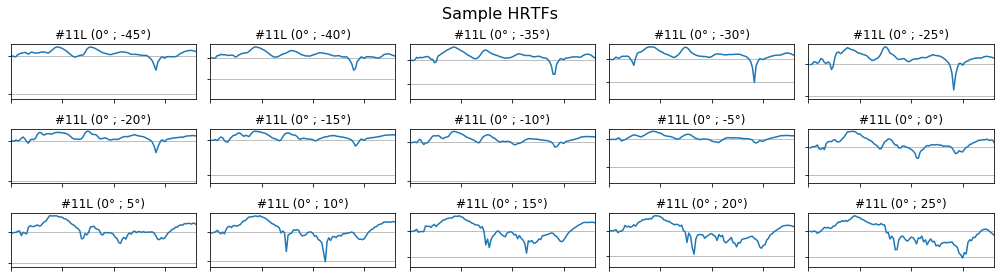

### Apply PCA on train

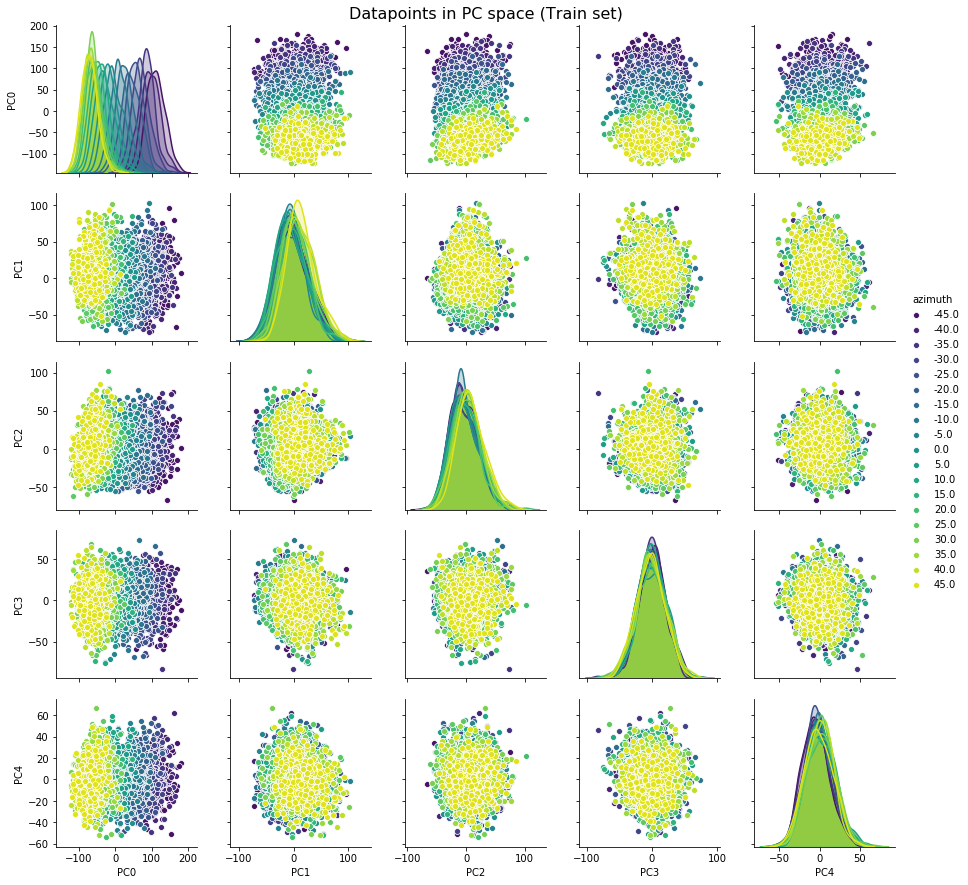

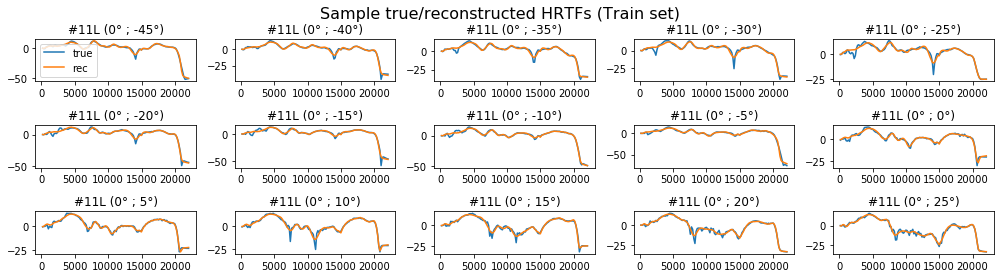

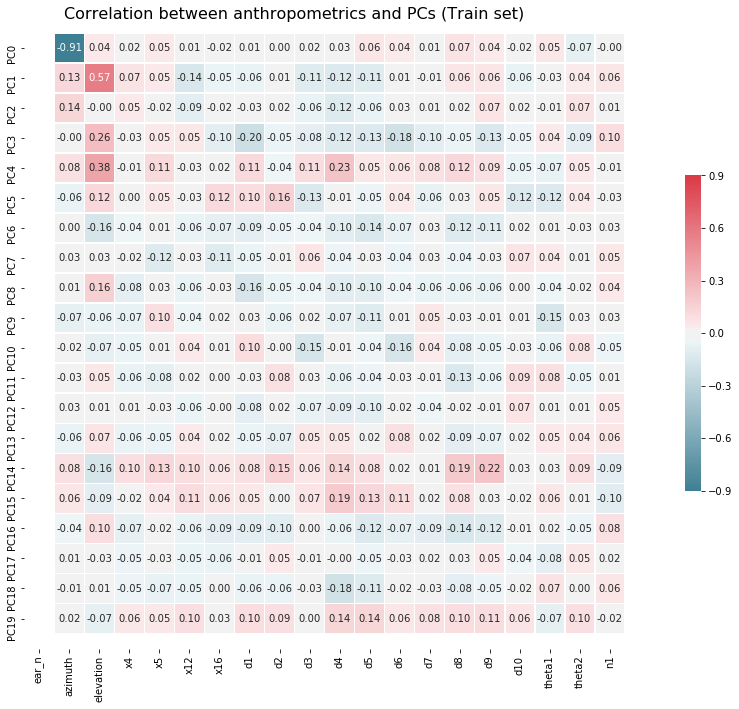

Max SD (train): 1.6780525722902513


### Apply PCA on test

Max SD (test): 1.4927933645698401


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_01
Training dnn_73610567_fold_01 from 0 to 100..


loss: 187.6227, val_loss: 199.8704: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


### Apply PCA/DNN model on train

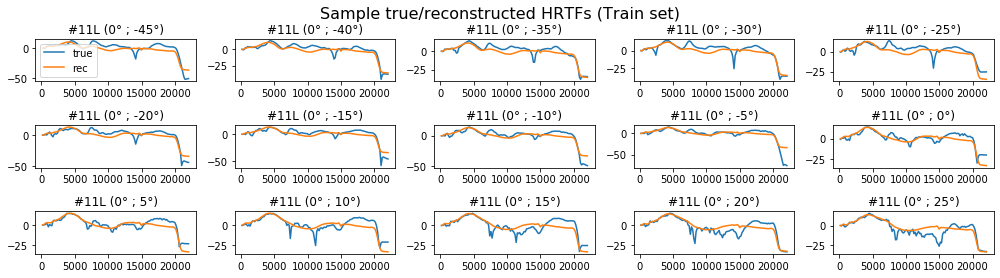

SD (train): 4.575692272614795


### Apply PCA/DNN model on test

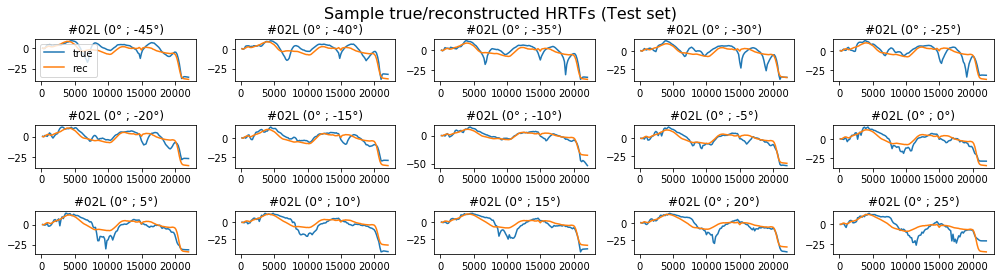

SD (test): 4.557528489663021


## Fold 2/10

100%|██████████| 3249/3249 [00:02<00:00, 1114.29it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 1.6601612388870395


### Apply PCA on test

Max SD (test): 1.7733797244860405


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_02
Training dnn_73610567_fold_02 from 0 to 100..


loss: 185.4128, val_loss: 193.5898: 100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


### Apply PCA/DNN model on train

SD (train): 4.489718252723287


### Apply PCA/DNN model on test

SD (test): 4.688914314432791


## Fold 3/10

100%|██████████| 3249/3249 [00:02<00:00, 1119.98it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 1.6681940022593946


### Apply PCA on test

Max SD (test): 1.629019418786589


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_03
Training dnn_73610567_fold_03 from 0 to 100..


loss: 190.5902, val_loss: 163.9875: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


### Apply PCA/DNN model on train

SD (train): 4.5805553589330765


### Apply PCA/DNN model on test

SD (test): 4.306408113051546


## Fold 4/10

100%|██████████| 3249/3249 [00:02<00:00, 1118.94it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 1.654482425197794


### Apply PCA on test

Max SD (test): 1.7120700868886163


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_04
Training dnn_73610567_fold_04 from 0 to 100..


loss: 187.9143, val_loss: 203.4127: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


### Apply PCA/DNN model on train

SD (train): 4.5467062522898525


### Apply PCA/DNN model on test

SD (test): 4.955572855041968


## Fold 5/10

100%|██████████| 3249/3249 [00:02<00:00, 1112.56it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 1.6579336768610449


### Apply PCA on test

Max SD (test): 1.809271109731583


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_05
Training dnn_73610567_fold_05 from 0 to 100..


loss: 191.4446, val_loss: 189.6667: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


### Apply PCA/DNN model on train

SD (train): 4.570402692846638


### Apply PCA/DNN model on test

SD (test): 4.693058630162095


## Fold 6/10

100%|██████████| 3249/3249 [00:02<00:00, 1117.36it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 1.6610181805259594


### Apply PCA on test

Max SD (test): 1.711514088661412


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_06
Training dnn_73610567_fold_06 from 0 to 100..


loss: 193.2630, val_loss: 168.8484: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


### Apply PCA/DNN model on train

SD (train): 4.613954818822816


### Apply PCA/DNN model on test

SD (test): 4.310877499642874


## Fold 7/10

100%|██████████| 3249/3249 [00:02<00:00, 1114.51it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 1.6665013437268406


### Apply PCA on test

Max SD (test): 1.643143268137587


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_07
Training dnn_73610567_fold_07 from 0 to 100..


loss: 184.7508, val_loss: 232.8447: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


### Apply PCA/DNN model on train

SD (train): 4.504011182180196


### Apply PCA/DNN model on test

SD (test): 5.0566164317390125


## Fold 8/10

100%|██████████| 3249/3249 [00:02<00:00, 1103.71it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 1.6509131696208124


### Apply PCA on test

Max SD (test): 1.821566926300502


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_08
Training dnn_73610567_fold_08 from 0 to 100..


loss: 187.6999, val_loss: 170.9396: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


### Apply PCA/DNN model on train

SD (train): 4.512357112943147


### Apply PCA/DNN model on test

SD (test): 4.583336653286649


## Fold 9/10

100%|██████████| 3249/3249 [00:03<00:00, 1074.95it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 1.6698766976708057


### Apply PCA on test

Max SD (test): 1.635437454130387


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_09
Training dnn_73610567_fold_09 from 0 to 100..


loss: 184.8828, val_loss: 214.0636: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


### Apply PCA/DNN model on train

SD (train): 4.473546857485193


### Apply PCA/DNN model on test

SD (test): 4.991114605175613


## Fold 10/10

100%|██████████| 3249/3249 [00:02<00:00, 1116.18it/s]


train set: (29241, 128)
test set:  (3249, 128)


### Apply PCA on train

Max SD (train): 1.653324302820001


### Apply PCA on test

Max SD (test): 1.727631179068738


### Train DNN model


train set: (29241, 27)
test set:  (3249, 27)
Training log: ./logs/dnn_73610567_fold_10
Training dnn_73610567_fold_10 from 0 to 100..


loss: 187.3804, val_loss: 185.8221: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


### Apply PCA/DNN model on train

SD (train): 4.530643176720678


### Apply PCA/DNN model on test

SD (test): 4.66196860519109


In [641]:
# data structures
fold_results = []

log_id = int(time.time()) % 99999999
kf = KFold(n_splits=n_splits)
for i, indexes in enumerate(kf.split(ids)):
    train_index, test_index = indexes
    display(Markdown(f'## Fold {i+1}/{n_splits}'))
    
    # load hrtf data
    time.sleep(0.2)
    (x_train, y_train), (x_test, y_test), (x_train_mean, x_train_std) = load_hrtf_sets(train_index, test_index)
    time.sleep(0.2)
    if i==0:
        plot_norm_hrtfs(x_train, y_train)
    
    pcadnn = PCADNN()
    # train PCA model
    pcadnn.pca_train(x_train, n_pc=n_pc)
    
    # process train data
    display(Markdown('### Apply PCA on train'))
    x_train_pca, x_train_rec = pcadnn.pca_compress(x_train)
    x_train_pca_df = pcadnn.pc_to_df(x_train_pca, y_train)
    sd_train_rec = calc_sd(x_train, x_train_rec, x_train_mean, x_train_std, f_range)
    if i==0:
        plot_pca_pairs(x_train_pca_df, 'Train')
        plot_rec_hrtf(x_train, x_train_rec, y_train, 'Train')
        plot_corr(x_train_pca_df, y_train, 'Train')
    print(f'Max SD (train): {sd_train_rec.mean()}')
    
    # process test data
    display(Markdown('### Apply PCA on test'))
    x_test_pca, x_test_rec = pcadnn.pca_compress(x_test)
    x_test_pca_df = pcadnn.pc_to_df(x_test_pca, y_test)
    sd_test_rec = calc_sd(x_test, x_test_rec, x_train_mean, x_train_std, f_range)
#     if i==0:
#         plot_pca_pairs(x_test_pca_df, 'Test')
#         plot_rec_hrtf(x_test, x_test_rec, y_test, 'Test')
#         plot_corr(x_test_pca_df, y_test, 'Test')
    print(f'Max SD (test): {sd_test_rec.mean()}')
    
    # load anthropometric/pca data and train DNN
    display(Markdown('### Train DNN model'))
    print()
    (x_train_dnn, y_train_dnn), (x_test_dnn, y_test_dnn) = load_dnndata_sets(x_train_pca, y_train, x_test_pca, y_test)
    model_name = f'dnn_{log_id}_fold_{i+1:02}'
    pcadnn.dnn_train(x_train_dnn, y_train_dnn, x_test_dnn, y_test_dnn, filters_layers, batch_size, epochs, model_name)
    
    # process train data
    display(Markdown('### Apply PCA/DNN model on train'))
    pred_train = pcadnn.model_apply(x_train_dnn)
    sd_train_pred = calc_sd_minimize(x_train, pred_train, x_train_mean, x_train_std, f_range)
    if i==0:
        plot_rec_hrtf(x_train, pred_train, y_train, 'Train')
    print(f'SD (train): {sd_train_pred.mean()}')
    
    # process test data
    display(Markdown('### Apply PCA/DNN model on test'))
    pred_test = pcadnn.model_apply(x_test_dnn)
    sd_test_pred = calc_sd_minimize(x_test, pred_test, x_train_mean, x_train_std, f_range)
    if i==0:
        plot_rec_hrtf(x_test, pred_test, y_test, 'Test')
    print(f'SD (test): {sd_test_pred.mean()}')

    fold_results.append({
        'sd_max_train': sd_train_rec.mean(),
        'sd_max_test': sd_test_rec.mean(),
        'sd_train': sd_train_pred.mean(),
        'sd_test': sd_test_pred.mean(),
        'fold': i+1
    })
    
#     if i > 1:
#         print('FOrCE QUiTTiNG')
#         break
    
results_df = pd.DataFrame(fold_results)

# Results

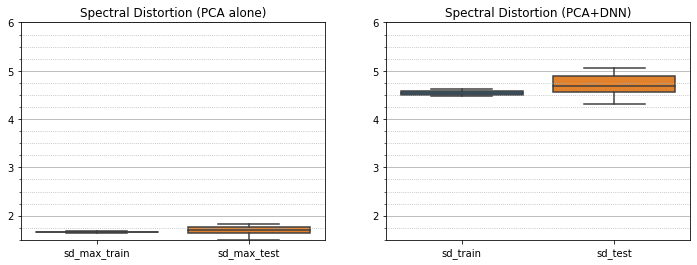

In [642]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(data=results_df[['sd_max_train', 'sd_max_test']], ax=ax[0])
ax[0].set_title('Spectral Distortion (PCA alone)')
format_boxwhisker(ax[0])
sns.boxplot(data=results_df[['sd_train', 'sd_test']], ax=ax[1])
ax[1].set_title('Spectral Distortion (PCA+DNN)')
format_boxwhisker(ax[1])
plt.show()

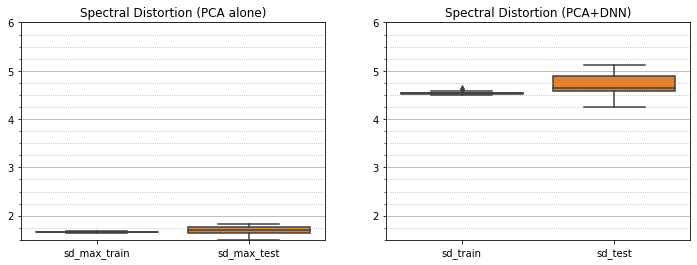

sd_max_train    1.662044
sd_max_test     1.695483
sd_train        4.539975
sd_test         4.682132
dtype: float64

In [618]:
def format_boxwhisker(ax):
    ax.set_ylim([1.5, 6.0001])
    ax.set_yticks(np.arange(2, 6.0001, 1))
    ax.grid(True, which='major', axis='y', linestyle='-')
    ax.set_yticks(np.arange(1.5, 6.0001, 0.25), minor=True)
    ax.grid(True, which='minor', axis='y', linestyle=':')

results_df = pd.DataFrame(fold_results)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(data=results_df[['sd_max_train', 'sd_max_test']], ax=ax[0])
ax[0].set_title('Spectral Distortion (PCA alone)')
format_boxwhisker(ax[0])
sns.boxplot(data=results_df[['sd_train', 'sd_test']], ax=ax[1])
ax[1].set_title('Spectral Distortion (PCA+DNN)')
format_boxwhisker(ax[1])
plt.show()

results_df.mean()

In [644]:
results_df.mean()

sd_max_train    1.662046
sd_max_test     1.695583
sd_train        4.539759
sd_test         4.680540
fold            5.500000
dtype: float64

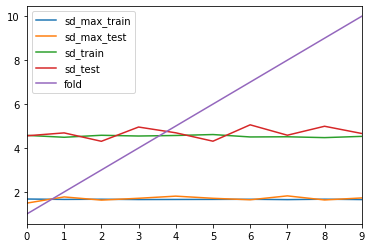

In [645]:
results_df.plot()

In [ ]:
res_train = y_train[['id', 'elevation', 'azimuth']].copy()
res_train['SD'] = sd

# spectral distortion on train data (various sub-groupings)
fig, axs = plt.subplots(3,1, figsize=(18,6))
res_train.groupby(['id']).mean()['SD'].plot.bar(ax=axs[0])
res_train.groupby(['azimuth']).mean()['SD'].plot.bar(ax=axs[1])
res_train.groupby(['elevation']).mean()['SD'].plot.bar(ax=axs[2])
fig.tight_layout()
print('mean SD (train)= ', res_train['SD'].mean())